In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import keras

from tensorflow.keras.datasets import cifar100 #Kullanacağımız veriseti
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping # Model overfitting problemiyle karşılaştığı için

from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data augmentation için
from tensorflow.keras.preprocessing import image

from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import plot_model #Modeli çizmek için

from sklearn.metrics import confusion_matrix, classification_report # Confusion matrisi için

In [2]:
# CIFAR-100 verisetini eğitim ve test olarak ayırmak üzere indirdim.
(train_image, train_label), (test_image, test_label) = cifar100.load_data()

169017344/169001437 [==============================] - 2s 0us/step


In [3]:
# Verisetinde toplam 50000 eğitim verisi, 10000 test verisi bulunur.
print(train_image.shape, train_label.shape)
print(test_image.shape, test_label.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
# Benim okul numarama göre belirlenen sınıflar şunlardır:
# 19=cattle 22=clock 37=house 49=mountain 61=plate 86=telephone 90=train
my_classes = dict({19:"cattle",22:"clock",37:"house",49:"mountain",61:"plate",86:"telephone",90:"train"})

In [5]:
# Verisetinden belirlenen sınıfları çıkarıp dosyalara kaydeden fonksiyon.
def save_images(x,y,classes,file_path):
    for i,j in classes.items():
        class_path = os.path.join(file_path, j)
        os.mkdir(class_path)
        photos = x[y[:,0] == i]
        for k,photo in enumerate(photos):
            plt.imsave(class_path +"/"+ str(k)+".png",photo)   

In [6]:
# Verisetinde kullandığım sınıfları cifar100_classes isimli dosyaya kaydettim.
dataset_path = "cifar100_classes"

os.mkdir(dataset_path)
train_dir = os.path.join(dataset_path, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(dataset_path, 'test')
os.mkdir(test_dir)

In [7]:
save_images(train_image,train_label,my_classes,train_dir)
save_images(test_image,test_label,my_classes,test_dir)

In [8]:
print("Working Directory Contents:", os.listdir(train_dir))

Working Directory Contents: ['train', 'clock', 'mountain', 'telephone', 'cattle', 'plate', 'house']


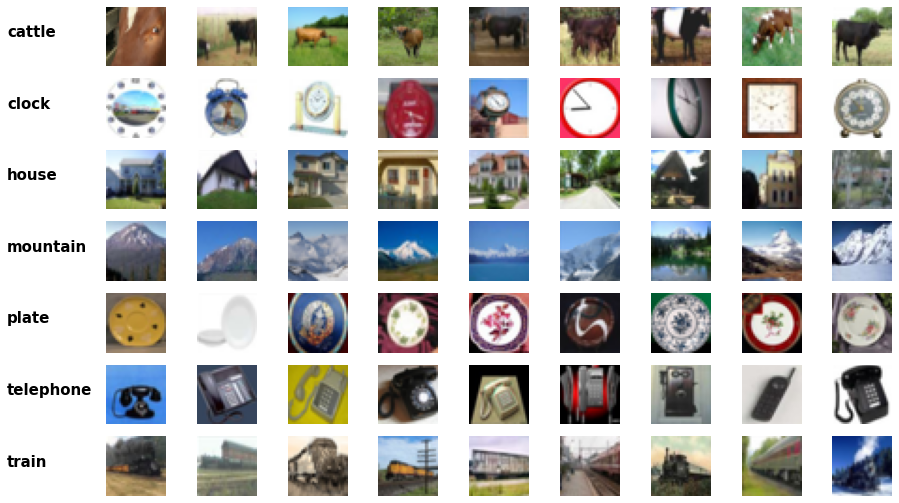

In [9]:
# Belirlenen sınıfların örnek görüntüsünü alan fonksiyon.
def show_class_photos():
  fig,ax = plt.subplots(7,10,figsize=(16,9))

  labels = list(my_classes.keys())

  for i in range(7):
      photos = train_image[train_label[:,0] == labels[i]]
      ax[i,0].axis("off")
      ax[i,0].text(0,0.5,my_classes[labels[i]], fontsize=15, fontweight = 'bold')
      for j in range(1,10):
          ax[i,j].axis("off")
          ax[i,j].imshow(photos[j])
          
  plt.show()

# Sınıflardan örnekler gösterdim.
show_class_photos()

In [10]:
# Daha fazla veri örneğine sahip olmak için Data Augmentation gerçekleştirdim.
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         featurewise_center=False,             # Giriş verilerinin ortalamasının sıfırlanması.
                                         samplewise_center=False,              # Her örnek verinin ortalamasının 0'a eşitlenmesi.
                                         featurewise_std_normalization=False,  # Giriş verilerinin, verisetinin standart varyans değerine bölünmesi.
                                         samplewise_std_normalization=False,   # Her verinin standart varyans değerine bölünmesi.
                                         zca_whitening=False,                  # "ZCA whitening" metodunun uygulanması.
                                         rotation_range=0,                     # Resimlerin bir sınır aralığında rastgele döndürülmesi.
                                         width_shift_range=0.1,                # Görüntüleri rastgele olarak yatay olarak kaydırılır.
                                         height_shift_range=0.1,               # Görüntüleri rastgele olarak dikey olarak kaydırılır.
                                         shear_range=0.15,                     # Görüntüler rastgele kırpılır.
                                         zoom_range=0.15,                      # Görüntüler rastgele yakınlaştırılır.
                                         horizontal_flip=True,                 # Görüntüler yatay düzlemde rastgele çevrilir.
                                         vertical_flip=False)                  # Resimlerin rastgele dikey olarak çevrilmesi.
        
test_datagen = image.ImageDataGenerator(rescale=1./255)
train_data_gen = train_datagen.flow_from_directory(directory = train_dir, 
                                                   target_size = (32,32), 
                                                   class_mode = "categorical", 
                                                   batch_size = 50, # Her batch 50 eğitim görüntüsü içerir.
                                                   shuffle=True,
                                                   seed=42)                                                   
test_data_gen = test_datagen.flow_from_directory(directory = test_dir, 
                                                 target_size = (32,32),
                                                 class_mode = "categorical",
                                                 batch_size = 50,
                                                 shuffle=False, 
                                                 seed=42)

Found 3500 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [11]:
# Kendi sınıflarımı kullanmak üzere ImageDataGenerator yineleyiciden eğitim ve test verilerini aldım.
train_data, train_labels = train_data_gen.next()
test_data, test_labels = test_data_gen.next()

In [12]:
# Okul numaramda belirlenen sınıflar 7 taneydi.
# 7 sınıfta toplamda 3500 eğitim verisi, 700 test verisi bulunur.
print(train_data_gen.samples)
print(test_data_gen.samples)

3500
700


In [13]:
# Modeli oluşturdum.

model=Sequential()
model.add(Conv2D(64, (3,3),
                 activation='relu', 
                 padding='same',
                 strides = (1,1),
                 input_shape=(32,32,3)))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3,3),
                 padding='same',
                 activation='relu'
                 ))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(len(my_classes),activation="softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_data_gen,
                    steps_per_epoch=train_data_gen.samples//50,
                    epochs=34,
                    validation_data=test_data_gen,
                    validation_steps=test_data_gen.samples//50)

Epoch 1/34
70/70 [==============================] - 16s 70ms/step - loss: 1.8019 - accuracy: 0.2637 - val_loss: 1.7469 - val_accuracy: 0.2800
Epoch 2/34
70/70 [==============================] - 5s 67ms/step - loss: 1.5259 - accuracy: 0.3911 - val_loss: 1.5565 - val_accuracy: 0.4057
Epoch 3/34
70/70 [==============================] - 5s 71ms/step - loss: 1.3962 - accuracy: 0.4331 - val_loss: 1.4668 - val_accuracy: 0.4600
Epoch 4/34
70/70 [==============================] - 5s 67ms/step - loss: 1.3288 - accuracy: 0.4694 - val_loss: 1.3885 - val_accuracy: 0.5029
Epoch 5/34
70/70 [==============================] - 5s 67ms/step - loss: 1.2158 - accuracy: 0.5197 - val_loss: 1.2645 - val_accuracy: 0.5229
Epoch 6/34
70/70 [==============================] - 5s 66ms/step - loss: 1.1734 - accuracy: 0.5294 - val_loss: 1.1707 - val_accuracy: 0.5914
Epoch 7/34
70/70 [==============================] - 5s 67ms/step - loss: 1.1116 - accuracy: 0.5657 - val_loss: 1.1464 - val_accuracy: 0.5986
Epoch 8/34
7

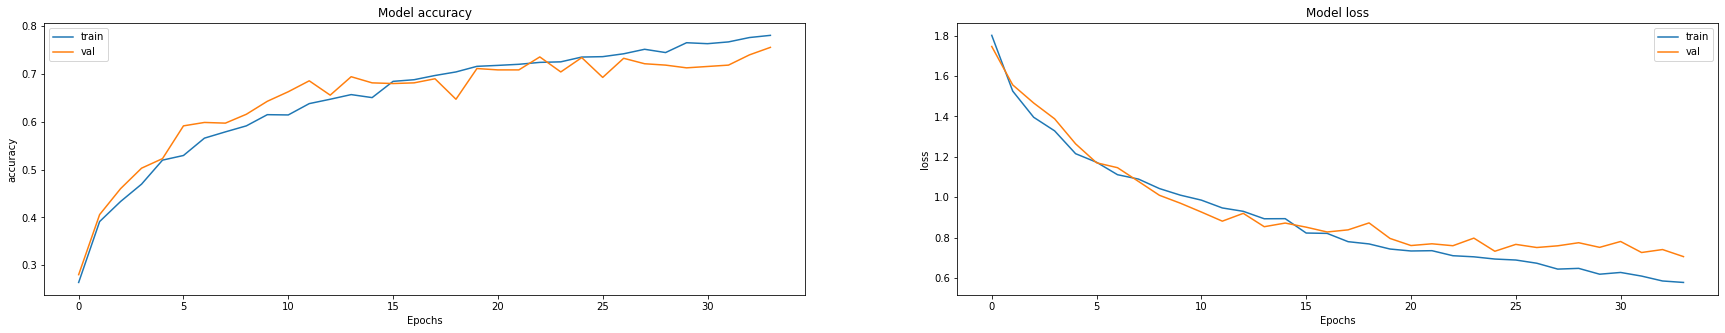

In [16]:
#Eğitim sırasındaki metriklerin (accuracy, loss) eğilimlerini çizme

fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [17]:
train_scores = model.evaluate(train_data_gen, steps=train_data_gen.samples//50)
test_scores = model.evaluate(test_data_gen, steps=test_data_gen.samples//50)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

14/14 [==============================] - 0s 23ms/step - loss: 0.7059 - accuracy: 0.7557
Training Accuracy: 83.57%
Testing Accuracy: 75.57%


In [18]:
# Her batch 50 eğitim görüntüsü içerdiği için bir batchteki tahmin edilen sınıflara bakmak istedim.
val_image_batch, val_label_batch = next(iter(test_data_gen))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (50, 32, 32, 3)


In [19]:
dataset_labels = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cattle' 'Clock' 'House' 'Mountain' 'Plate' 'Telephone' 'Train']


In [20]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (50, 7)


In [21]:
# Her batch 50 eğitim görüntüsü içerdiği için bir batchteki tahmin edilen sınıflara yani toplamda 50 sınıfa baktım.
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)
print(len(predicted_labels))

['Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle'
 'House' 'House' 'Cattle' 'Cattle' 'House' 'Telephone' 'Cattle' 'Cattle'
 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Clock' 'Cattle'
 'Mountain' 'Cattle' 'House' 'Cattle' 'Cattle' 'Train' 'Telephone'
 'Cattle' 'Cattle' 'Telephone' 'Cattle' 'Cattle' 'Cattle' 'Cattle'
 'Cattle' 'House' 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle' 'Cattle'
 'Cattle' 'Cattle' 'Cattle' 'Cattle']
50


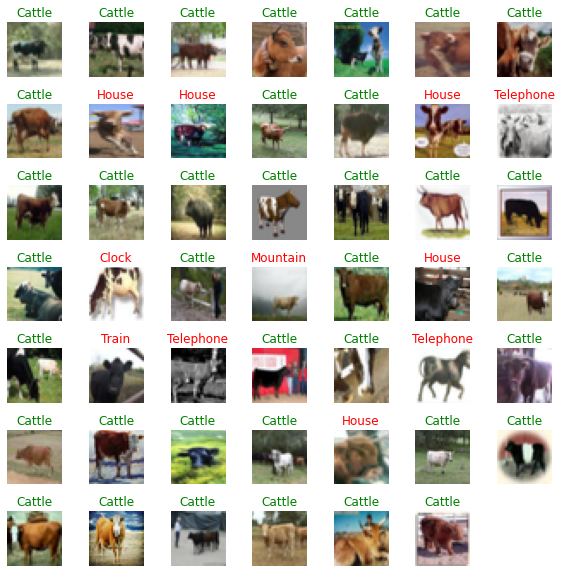

In [23]:
# Bir batchteki tahmin edilen resimlerin doğruluğunu gösterdim.
# Resim doğru tahmin edilmişse sınıf ismi yeşil renklidir.
# Resim yanlış tahmin edilmişse sınıf ismi kırmızı renklidir.
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for n in range(0, 48):
  plt.subplot(7,7,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')

In [30]:
# Karmaşıklık matrisi (confution matrix) ve sınıflandırma raporu oluşturdum.
Labels = ['cattle', 'house', 'train', 'telephone', 'plate', 'clock', 'mountain']

Predictions = model.predict(test_data_gen, test_data_gen.samples // 50)
predictions = np.argmax(Predictions, axis=1)

print(confusion_matrix(test_data_gen.classes, predictions))
cm = confusion_matrix(test_data_gen.classes, predictions)

print(classification_report(test_data_gen.classes, predictions, target_names=Labels))

[[86  1  6  1  0  5  1]
 [ 5 63  2  2 13 10  5]
 [ 7  1 85  3  0  0  4]
 [ 1  1 11 80  1  2  4]
 [ 2 22  0  1 73  2  0]
 [ 1 15  2  1 12 67  2]
 [ 1  6 11  6  0  1 75]]
              precision    recall  f1-score   support

      cattle       0.83      0.86      0.85       100
       house       0.58      0.63      0.60       100
       train       0.73      0.85      0.78       100
   telephone       0.85      0.80      0.82       100
       plate       0.74      0.73      0.73       100
       clock       0.77      0.67      0.72       100
    mountain       0.82      0.75      0.79       100

    accuracy                           0.76       700
   macro avg       0.76      0.76      0.76       700
weighted avg       0.76      0.76      0.76       700



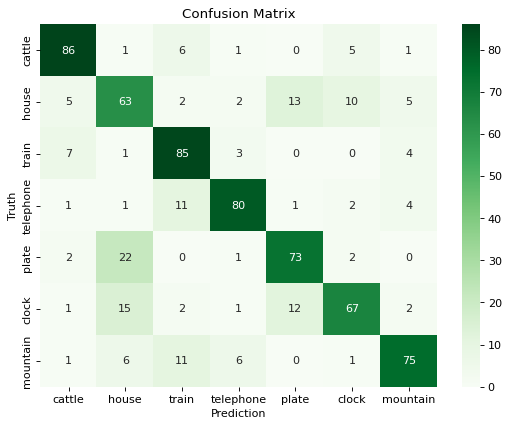

In [29]:
# Karmaşıklık matrisi (confusion matrix) bir grafikte gösterdim.
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=Labels, yticklabels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [39]:
# Görüntüleri gösteren fonksiyon.
def show_image(img_path):
  img = mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  return plt.show()

def predict_label(img_path):
	test_image = image.load_img(img_path, target_size=(32,32))
	test_image = image.img_to_array(test_image)/255.0
	test_image = test_image.reshape(1, 32,32,3)
	
	predict_x=model.predict(test_image) 
	classes_x=np.argmax(predict_x,axis=1)
 
	return Labels[classes_x[0]], show_image(img_path)

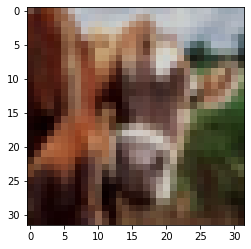

('cattle', None)

In [40]:
predict_label('/content/cifar100_classes/test/cattle/6.png')

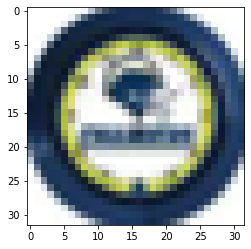

('house', None)

In [41]:
predict_label('/content/cifar100_classes/test/clock/10.png')

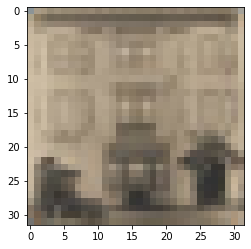

('cattle', None)

In [42]:
predict_label('/content/cifar100_classes/test/house/7.png')

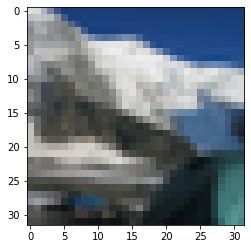

('telephone', None)

In [43]:
predict_label('/content/cifar100_classes/test/mountain/21.png')

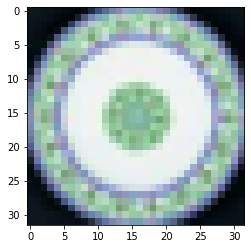

('plate', None)

In [44]:
predict_label('/content/cifar100_classes/test/plate/25.png')

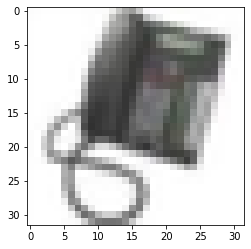

('clock', None)

In [45]:
predict_label('/content/cifar100_classes/test/telephone/35.png')

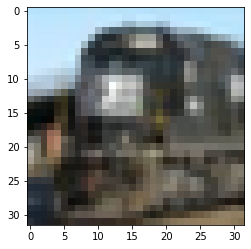

('train', None)

In [46]:
predict_label('/content/cifar100_classes/test/train/44.png')

In [48]:
# Bütün sınıfların tahmin edilen değerlerle karşılaştırılmasını bir "results.csv" dosyasına kaydettim.
# Bu dosyada hangi verilerin doğru hangi verilerin yanlış olduğunu net bir şekilde görürüz.
batch_size = 50
STEP_SIZE_TEST=test_data_gen.n//test_data_gen.batch_size
test_data_gen.reset()
pred=model.predict(test_data_gen, steps=STEP_SIZE_TEST, verbose=1)

14/14 [==============================] - 1s 45ms/step


In [49]:
predicted_class_indices=np.argmax(pred,axis=1)

In [50]:
labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [51]:
filenames=test_data_gen.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

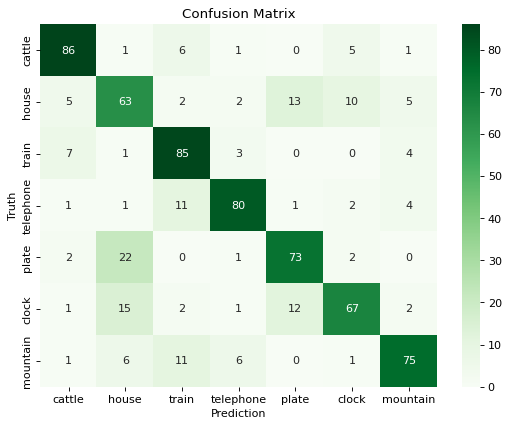

In [52]:
c_matrix = confusion_matrix(test_data_gen.classes, predicted_class_indices)

# Karmaşıklık matrisi (confution matrix) bir grafikte gösterdim.
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(c_matrix, cmap='Greens', annot=True, fmt='d', xticklabels=Labels, yticklabels=Labels)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [34]:
# Modelin kaydedileceği yer belirlenir
model.save(os.path.join("./savedmodels/","cifar100_model.h5"))

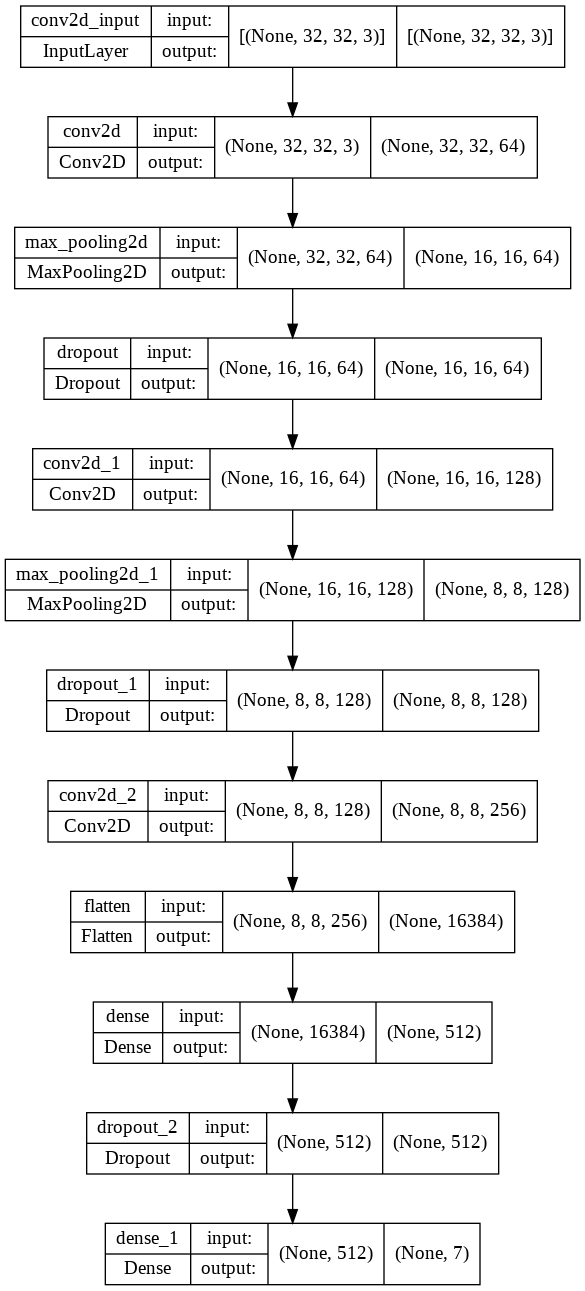

In [35]:
pretrained_model = keras.models.load_model("/content/savedmodels/cifar100_model.h5")

plot_model(pretrained_model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

In [53]:
result = model.predict(test_image[1:2])
print(test_label[1])

[33]
